1. **Clean dataset** → remove corrupted images.
2. **Normalize images** → pixel values 0–1.
3. **Create train/validation datasets** → shuffle and batch.
4. **Build CNN model** → Conv2D, MaxPooling, Flatten, Dense, Dropout.
5. **Compile model** → optimizer, loss, metrics.
6. **Train model** → use `model.fit(train_ds, validation_data=val_ds, epochs=...)`.
7. **Check results** → plot accuracy/loss or evaluate on validation set.
8. **Save model** → `model.save(...)`.
9. **Deploy / predict** → load model and run predictions.


**Download and Unzip the Dataset**

In [24]:
!pip install kagglehub

import kagglehub

# Download dataset
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")
print("Path to dataset files:", path)



Using Colab cache for faster access to the 'dog-and-cat-classification-dataset' dataset.
Path to dataset files: /kaggle/input/dog-and-cat-classification-dataset


**Create Dataframes From Data. 1 = Cat , 0 = Dog**

In [42]:
# -------------------------------
# Step 1: Import required libraries
# -------------------------------
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

warnings.filterwarnings('ignore')

# -------------------------------
# Step 2: Prepare the DataFrame
# -------------------------------

# Base path to dataset
base_path = "/kaggle/input/dog-and-cat-classification-dataset/PetImages"

# Initialize lists
input_path = []  # store the path of images
label = []       # label: 0 for Cat, 1 for Dog

# Loop through each class folder
for class_name in os.listdir(base_path):  # class_name will be 'Cat' or 'Dog'
    class_path = os.path.join(base_path, class_name)
    for f in os.listdir(class_path):
        input_path.append(f)
        label.append(0 if class_name == "Cat" else 1)

# Create DataFrame
df = pd.DataFrame({
    "file": input_path,               # image file names
    "label": label                    # numeric labels
})

# Map numeric labels to class names
df['label_name'] = df['label'].map({0: 'Cat', 1: 'Dog'})

# Prepend subfolder to file column so generator can find images
df['file'] = df['label_name'] + '/' + df['file'] #It adds the subfolder name (Cat or Dog) in front of each filename so the generator can locate the images.

# -------------------------------
# Step 3: Check DataFrame info
# -------------------------------
print(df.head())
print(df['label_name'].value_counts())  # check number of cats and dogs


           file  label label_name
0  Dog/7981.jpg      1        Dog
1  Dog/6234.jpg      1        Dog
2  Dog/1269.jpg      1        Dog
3  Dog/3863.jpg      1        Dog
4  Dog/6241.jpg      1        Dog
label_name
Dog    12499
Cat    12499
Name: count, dtype: int64


**Explotary Data Analysis**

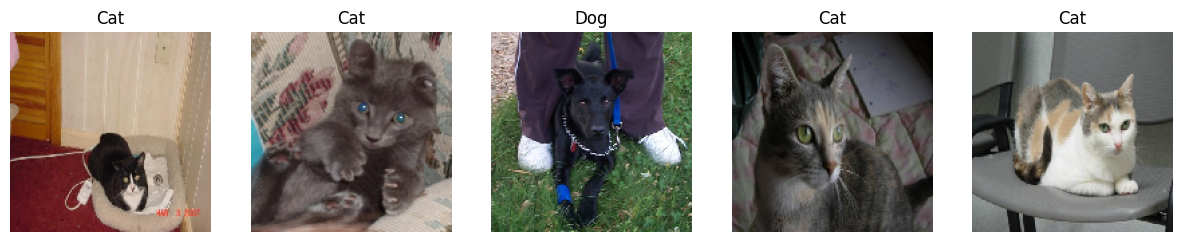

In [43]:
# -------------------------------
# Step 4: Display some sample images
# -------------------------------
sample = df.sample(5)

plt.figure(figsize=(15, 5))
for i, row in enumerate(sample.itertuples(), 1):
    img_path = os.path.join(base_path, str(row.label_name), str(row.file).split('/')[-1])  # full path
    img = load_img(img_path, target_size=(150, 150))
    plt.subplot(1, 5, i)
    plt.imshow(img)
    plt.title(row.label_name)
    plt.axis('off')
plt.show()

**Create DataGenerator for the images**

A **DataGenerator** is a Python object that **loads and preprocesses images in batches** during model training instead of loading all at once.
It helps **save memory** and can **apply real-time data augmentation** like rotation, flipping, or scaling.
Basically, it **feeds the model images batch by batch efficiently**.


In [49]:
# -------------------------------
# Step 5: Create ImageDataGenerator
# -------------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,            # normalize pixel values 0 to 1
    shear_range=0.2,           # randomly apply shearing
    zoom_range=0.2,            # randomly zoom in/out
    horizontal_flip=True,      # randomly flip images horizontally
    rotation_range=40,         # augment(rotation) images to avoid overfitting
    fill_mode='nearest'        # fill in new pixels
)

# -------------------------------
# Step 6: Create training generator
# -------------------------------
train_generator = train_datagen.flow_from_dataframe(
    df,                           # input DataFrame with file names and labels
    x_col="file",                 # column in df containing image file names (with subfolder)
    y_col="label_name",           # column in df containing labels
    target_size=(128, 128),       # resize all images to 150x150
    batch_size=16,                # number of images per batch
    class_mode="binary",          # for binary labels
    shuffle=True,                 # shuffle data each epoch
    directory=base_path           # base directory containing Cat and Dog folders
)


Found 24998 validated image filenames belonging to 2 classes.


**Model Creation**




In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# -------------------------------
# Step 1: Create CNN model
# -------------------------------
model = Sequential([

    # Input shape is 150x150 RGB images
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),# First convolutional layer: 32 filters, 3x3 kernel, ReLU activation
    MaxPooling2D(2,2), # First max pooling layer: reduce spatial dimensions by 2
    Conv2D(64, (3,3), activation='relu'), # Second convolutional layer: 64 filters, 3x3 kernel, ReLU activation
    MaxPooling2D(2,2),   # Second max pooling layer
    Conv2D(128, (3,3), activation='relu'),  # Third convolutional layer: 128 filters, 3x3 kernel, ReLU activation
    MaxPooling2D(2,2),# Third max pooling layer
    Flatten(), # Flatten layer: convert 3D feature maps to 1D vector for dense layers
    Dense(512, activation='relu'),# Fully connected dense layer with 512 neurons and ReLU activation
    Dropout(0.5),# Dropout layer to prevent overfitting (randomly disable 50% of neurons during training)
    Dense(1, activation='sigmoid') # Output layer: 1 neuron with sigmoid activation for binary classification (Cat vs Dog)
])

# -------------------------------
# Step 2: Compile the model
# -------------------------------
model.compile(
    loss='binary_crossentropy',          # use binary cross-entropy for 2-class classification
    optimizer='adam',                    # Adam optimizer for weight updates
    metrics=['accuracy']                 # evaluate the model using accuracy
)

# -------------------------------
# Step 3: Display model summary
# -------------------------------
model.summary()  # prints layer info, output shapes, and total parameters


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,329 (49.36 MB)

 Trainable params: 12,939,329 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

The CNN model has 3 convolutional layers with increasing filters (32 → 64 → 128), each followed by max pooling to reduce image size. The feature maps are flattened and passed through a dense layer of 512 neurons with dropout for regularization. The output layer has 1 neuron with sigmoid activation for binary classification (Cat vs Dog). The model has **19 million trainable parameters** and no non-trainable parameters. It’s ready to learn features from your images.


**Train the model**

In [54]:
# -------------------------------
# Step : Train the CNN model
# -------------------------------
history = model.fit(
    train_generator,           # training data generator
    steps_per_epoch=len(train_generator),  # number of batches per epoch
    epochs=5,                 # number of times to iterate over dataset
    verbose=1                  # display training progress
)


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 160s 100ms/step - accuracy: 0.5701 - loss: 0.6836
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 186s 91ms/step - accuracy: 0.7099 - loss: 0.5623
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 145s 93ms/step - accuracy: 0.7679 - loss: 0.4892
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 145s 93ms/step - accuracy: 0.7892 - loss: 0.4538
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 148s 95ms/step - accuracy: 0.8098 - loss: 0.4160


**Evaluate the model**

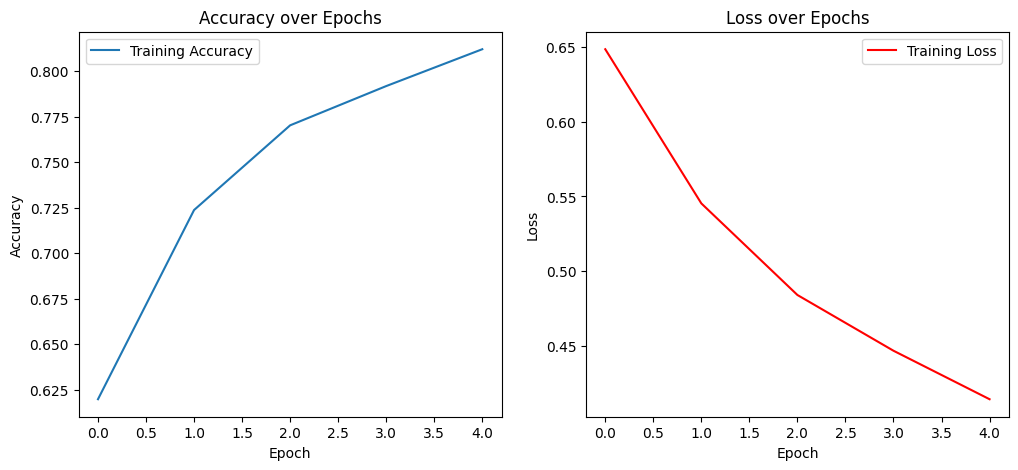

Final Training Accuracy: 81.21%
Final Training Loss: 0.4143


In [55]:
# -------------------------------
# Plot training accuracy and loss
# -------------------------------
plt.figure(figsize=(12,5))

# Plot accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Print final training accuracy and loss
final_acc = history.history['accuracy'][-1]
final_loss = history.history['loss'][-1]
print(f"Final Training Accuracy: {final_acc*100:.2f}%")
print(f"Final Training Loss: {final_loss:.4f}")


**Save the model**

In [59]:
# Save as HDF5
model.save("cat_dog_model.h5")

# # OR save as TensorFlow SavedModel
# model.save("cat_dog_model_tf", save_format='tf')


**Load saved model later**

In [60]:
from tensorflow.keras.models import load_model

# Load HDF5 model
model = load_model("cat_dog_model.h5")


**Prediction**

In [61]:
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# -------------------------------
# Step 9: Upload image
# -------------------------------
uploaded = files.upload()  # user selects image(s)

# -------------------------------
# Step 10: Predict and display results
# -------------------------------
for filename in uploaded.keys():
    # Load and preprocess image
    img = load_img(filename, target_size=(128,128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_array)[0][0]

    # Interpret and decorate output
    if prediction > 0.5:
        label = "Dog 🐶"
        confidence = prediction * 100
    else:
        label = "Cat 🐱"
        confidence = (1 - prediction) * 100

    print("==========================================")
    print(f"File: {filename}")
    print(f"Prediction: {label}")
    print(f"Confidence: {confidence:.2f}%")
    print("==========================================\n")


**Download The Model**

In [64]:
from google.colab import files

files.download("cat_dog_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>